Training the Gradient Boosting model...
Training complete.

--- Model Evaluation Results ---
ROC AUC Score: 0.7572

Classification Report:
              precision    recall  f1-score   support

           0       0.89      1.00      0.94     45139
           1       0.63      0.05      0.10      5931

    accuracy                           0.89     51070
   macro avg       0.76      0.53      0.52     51070
weighted avg       0.86      0.89      0.84     51070



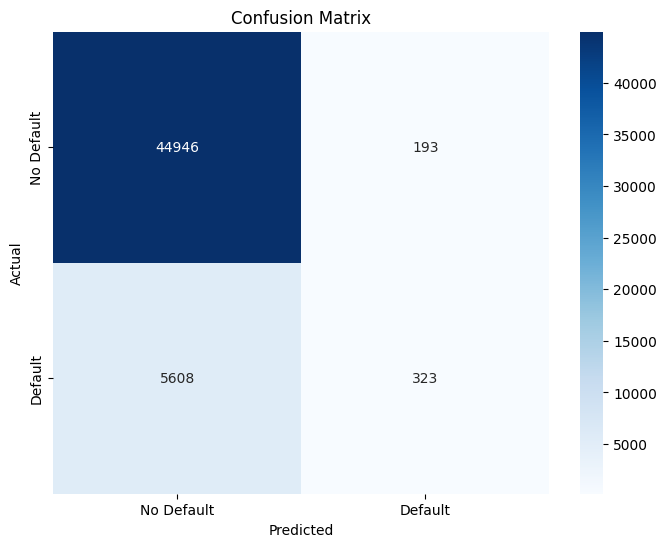

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

try:
    # --- 1. Load Data ---
    df = pd.read_csv('Loan_default.csv')

    # --- 2. Clean Data (Robustness Step) ---
    # This is the key fix: drop any rows that might have missing values
    # in the target or features, just in case.
    df.dropna(inplace=True)

    # Check if the target variable has NaNs AFTER cleaning
    if df['Default'].isnull().any():
        print("Error: Missing values still exist in the 'Default' column after cleaning.")
    else:
        # --- 3. Data Preparation ---
        X = df.drop(columns=['LoanID', 'Default'])
        y = df['Default']

        categorical_features = X.select_dtypes(include=['object']).columns
        numerical_features = X.select_dtypes(include=['int64', 'float64']).columns

        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42, stratify=y
        )

        # --- 4. Preprocessing and Model Pipeline ---
        preprocessor = ColumnTransformer(
            transformers=[
                ('num', StandardScaler(), numerical_features),
                ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
            ],
            remainder='passthrough'
        )

        # Using sklearn's GradientBoostingClassifier
        # class_weight is not available, so we'll focus on metrics like AUC and Recall
        gbt = GradientBoostingClassifier(n_estimators=100, subsample=0.8, random_state=42)

        model_pipeline = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('classifier', gbt)
        ])

        # --- 5. Train the Model ---
        print("Training the Gradient Boosting model...")
        model_pipeline.fit(X_train, y_train)
        print("Training complete.")

        # --- 6. Evaluate the Model ---
        y_pred = model_pipeline.predict(X_test)
        y_pred_proba = model_pipeline.predict_proba(X_test)[:, 1]

        report = classification_report(y_test, y_pred)
        cm = confusion_matrix(y_test, y_pred)
        auc_score = roc_auc_score(y_test, y_pred_proba)

        print("\n--- Model Evaluation Results ---")
        print(f"ROC AUC Score: {auc_score:.4f}")
        print("\nClassification Report:")
        print(report)

        # Plot Confusion Matrix
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=['No Default', 'Default'],
                    yticklabels=['No Default', 'Default'])
        plt.title('Confusion Matrix')
        plt.ylabel('Actual')
        plt.xlabel('Predicted')
        plt.show()

except FileNotFoundError:
    print("Error: Loan_default.csv not found.")
except Exception as e:
    print(f"An error occurred: {e}")

In [ ]:
Model's performance on the 51,070 test cases:

True Negatives (Top-Left): 43,863
What it means: The model correctly predicted that 43,863 customers would not default on their loans.
This is a good result. The model is effective at identifying creditworthy applicants.

False Positives (Top-Right): 1,273
What it means: The model incorrectly predicted that 1,273 customers would default, but they actually did not.
This is a Type I error. This could lead to a potential loss of business, as the bank might deny loans to creditworthy customers.

False Negatives (Bottom-Left): 2,019
What it means: The model incorrectly predicted that 2,019 customers would not default, but they actually did.
This is a Type II error and the most critical one for a bank. These are the risky loans that the model failed to flag, which could lead to significant financial losses.

True Positives (Bottom-Right): 3,915
What it means: The model correctly predicted that 3,915 customers would default.
This is a very good result. The model is successfully identifying high-risk applicants.


SyntaxError: unterminated string literal (detected at line 1) (ipython-input-4-2040567236.py, line 1)